In [2]:
import torch
import torch.nn as nn
from fastai.vision.all import *

In [25]:
# import gdown
# # download the dataset
# url = "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"
# output = '../datasets/catface.tgz'
# gdown.download(url, output, quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM
To: /home/qiao/dev/giao/datasets/catface.tgz

  0%|                                                                                       | 0.00/4.33G [00:00<?, ?B/s]
  0%|                                                                               | 524k/4.33G [00:00<14:26, 5.00MB/s]
  0%|                                                                              | 1.57M/4.33G [00:00<12:53, 5.60MB/s]
  0%|                                                                              | 2.62M/4.33G [00:00<12:40, 5.70MB/s]
  0%|                                                                              | 3.67M/4.33G [00:00<12:06, 5.96MB/s]
  0%|                                                                              | 4.72M/4.33G [00:00<12:07, 5.95MB/s]
  0%|                                                                              | 5.77M/4.33G [00:00<11:51, 6.08MB/s]
  0%|                

  1%|█                                                                             | 61.3M/4.33G [00:14<13:02, 5.46MB/s]
  1%|█                                                                             | 62.4M/4.33G [00:14<17:37, 4.04MB/s]
  1%|█▏                                                                            | 63.4M/4.33G [00:14<16:26, 4.33MB/s]
  1%|█▏                                                                            | 64.5M/4.33G [00:14<15:07, 4.70MB/s]
  2%|█▏                                                                            | 65.5M/4.33G [00:15<14:03, 5.06MB/s]
  2%|█▏                                                                            | 66.6M/4.33G [00:15<13:10, 5.40MB/s]
  2%|█▏                                                                            | 67.6M/4.33G [00:15<12:40, 5.61MB/s]
  2%|█▏                                                                            | 68.7M/4.33G [00:15<12:08, 5.86MB/s]
  2%|█▎                         

KeyboardInterrupt: 

In [28]:
from zipfile import ZipFile

with ZipFile('../datasets/catface.tgz', 'r') as zip_ref:
    zip_ref.extractall()

In [29]:
import os

[x[0] for x in os.walk('cats')]

['cats',
 'cats/CAT_04',
 'cats/CAT_03',
 'cats/CAT_05',
 'cats/CAT_01',
 'cats/CAT_02',
 'cats/CAT_06',
 'cats/CAT_00']

In [30]:
for i in range(7):
    path = Path(f'CAT_0{i}')
    shutil.rmtree(path)

In [31]:
# use 'pathlib' to move all the files up one level
for i in range(7):
    paths = Path(f'cats/CAT_0{i}').ls()
    for path in paths:
        p = Path(path).absolute()
        par = p.parents[1] # ?
        p.rename(par/p.name)

In [32]:
path = Path('cats')
lbls = get_files(path, extensions = '.cat')
imgs = get_image_files(path)
test_eq(len(lbls), len(imgs))

<AxesSubplot:>

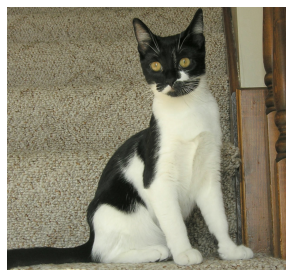

In [33]:
# visualizing the data
def img2kpts(f):
    return f'{str(f)}.cat'

fname = imgs[0]
img = PILImage.create(fname)
img.show()

In [37]:
import numpy as np

kpts = np.genfromtxt(img2kpts(fname))
print(kpts)

# It is, go back to the Kaggle and they describe how it is done. The number of points by default are 9 (the first value in our list):

# Left eye
# Right eye
# Mouth
# Left ear 1
# Left ear 2
# Left ear 3
# Right ear 1
# Right ear 2
# Right ear 3

[  9. 547. 216. 650. 203. 602. 292. 486. 171. 468.  43. 546. 110. 651.
  98. 709.   9. 721. 146.]


In [40]:
# seperate the keypoints into pairs and a tensor
def set_points(coords:array):
    kpts = []
    for i in range(1, int(coords[0]*2), 2):
        kpts.append([coords[i], coords[i+1]])
    return tensor(kpts)

In [41]:
pnts = set_points(kpts)
print(pnts)

tensor([[547., 216.],
        [650., 203.],
        [602., 292.],
        [486., 171.],
        [468.,  43.],
        [546., 110.],
        [651.,  98.],
        [709.,   9.],
        [721., 146.]])


In [42]:
def get_y(f:Path):
    # get keypoints for 'f' image
    pts = np.genfromtxt(img2kpts(f))
    return set_points(pts)

Now there is one more bit of cleaning we need to do, and that is to make sure all my points are within the bounds of my image. But how do I do this? Let's write a list of __bad_fnames__ in which we run the following test:  

1. Open an image and the points  
2. If any point is outside the image, remove the file  
3. If any point is negative, remove the file  

In [ ]:
bad_imgs = []
from name in imgs:
    im = PILImage.create(n_pxameme)
    y = get_y(name)
    